**Supervised Contrastive Learning**

* Paper: https://arxiv.org/abs/2004.11362
* Original code: https://github.com/google-research/google-research/tree/master/supcon
* Official pytorch code: https://github.com/HobbitLong/SupContrast

In [1]:
%reload_ext autoreload
%autoreload 2
from fastai.vision.all import *

# Data

In [2]:
path = untar_data(URLs.PETS) / 'images'

In [3]:
class PairTensorImage(TensorImage): pass

class DoubleAugment(DisplayedTransform):
    def __init__(self, enable=True): store_attr()
    def encodes(self, x:TensorImage): return PairTensorImage(x.repeat_interleave(2, dim=0) if self.enable else x)
    def encodes(self, x): return x.repeat_interleave(2, dim=0) if self.enable else x
    @contextmanager
    def disabled(self):
        if not self.enable: return
        self.enable = False
        try: yield
        finally: self.enable = True

In [4]:
tst = TensorImage(PILImage.create(path.ls()[2322]))[None]
f = DoubleAugment()
t = f(tst)
test_eq(tst.size(0), t.size(0)/2)
test_eq(t[0], t[1])

In [5]:
class ContrastiveCategorize(Categorize):
    def decodes(self, o): return Category(self.vocab[o]),o

def ConstrastiveCategoryBlock(vocab=None, sort=True, add_na=False):
    return TransformBlock(type_tfms=ContrastiveCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [6]:
double_augment = DoubleAugment()
tfms = [double_augment, Normalize.from_stats(*imagenet_stats)] + aug_transforms(size=224)

db = DataBlock(
    blocks=(ImageBlock, ConstrastiveCategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    splitter=RandomSplitter(),
    item_tfms=Resize(448),
    batch_tfms=tfms
)

dls = db.dataloaders(path, bs=64)

In [7]:
xb,yb = dls.one_batch(); xb.shape,yb.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [8]:
@typedispatch
def show_batch(x:PairTensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    max_n = (max_n//2)*2
    n = min(len(samples), max_n) // 2
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    figsize = figsize or (ncols*6, nrows*3)
    if ctxs is None: ctxs = get_grid(n, nrows=nrows, ncols=ncols, figsize=figsize)
    samples = L(chunked(samples[:max_n], 2)).starmap(
                lambda a,b: (torch.cat([a[0],b[0]], dim=2),
                            a[1][0] if a[1][0] == b[1][0] else TitledStr(f'{a[1][0]} | {b[1][0]}')))
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n//2, **kwargs)
    return ctxs

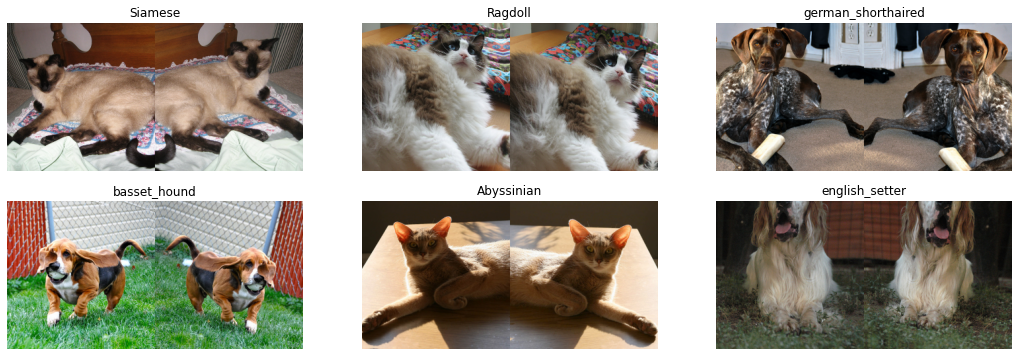

In [9]:
dls.show_batch(max_n=12)

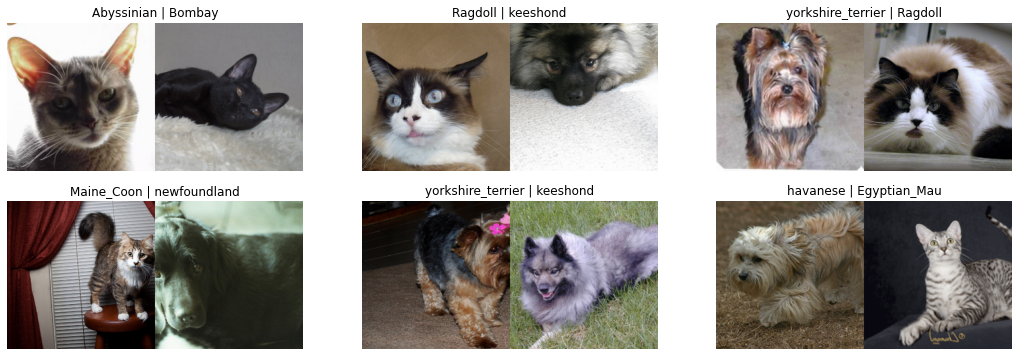

In [10]:
with double_augment.disabled(): dls.show_batch(max_n=12)

# Model

In [11]:
@module()
def L2Norm(self, x): return F.normalize(x, dim=1)

class ContrastiveModel(Module):
    def __init__(self, arch, dims=128, normalize=True, bn=False, concat_pool=False, pretrained=False):
        store_attr(but='arch')
        body = create_body(arch, pretrained=pretrained)
        pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        encoder = [body, pool, Flatten()]
        projection = [LinBnDrop(nf, nf, bn=bn, act=inplace_relu(), lin_first=True), nn.Linear(nf,dims)]
        
        if normalize: encoder.append(L2Norm()); projection.append(L2Norm())
        self.encoder = nn.Sequential(*encoder)
        self.projection = nn.Sequential(*projection)
        apply_init(self.projection)
        
    def forward(self, x): return self.projection(self.encoder(x))

ContrastMode = Enum('ContrastMode', 'All One')

class ContrastiveLoss(Module):
    def __init__(self, temp=0.07, base_temp=0.07, supervised=True, mode=ContrastMode.All, reduction='mean'):
        store_attr()
        
    def forward(self, output, target):
        embs1,embs2,lbls = output[::2],output[1::2],target[::2].view(-1,1)
        bs = lbls.size(0)
        fts = torch.cat([embs1,embs2], dim=0)
        if   self.mode == ContrastMode.All: anchor_fts,anchor_n = fts  ,2
        elif self.mode == ContrastMode.One: anchor_fts,anchor_n = embs1,1
        else: raise Exception(f'Invalid `mode`: {self.mode}')
        
        logits = (anchor_fts @ fts.T) / self.temp
        logits -= logits.max(dim=1, keepdim=True)[0].detach() # numerical stability

        mask = (lbls == lbls.T).float()
        mask = mask.repeat(anchor_n, 2)
        diagonal_mask = torch.ones_like(mask)
        torch.diagonal(diagonal_mask).fill_(0)
        mask *= diagonal_mask

        # compute log_prob
        exp_logits = logits.exp() * diagonal_mask
        log_prob = logits - exp_logits.sum(dim=1, keepdim=True).log()
        
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        
        loss = -self.temp/self.base_temp * mean_log_prob_pos
        loss = loss.view(anchor_n, bs).T.contiguous().view(-1)
        if self.reduction == 'mean': loss = loss.mean()
        return loss

In [12]:
m = ContrastiveModel(resnet34)
loss_func = ContrastiveLoss()
learn = Learner(dls, m, loss_func=loss_func)

In [13]:
with torch.no_grad():
    yb_ = m.cuda()(xb)
    loss = loss_func(yb_, yb)

yb_.shape, loss

(torch.Size([128, 128]), TensorCategory(4.8403, device='cuda:0'))

In [17]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,4.478861,4.382328,00:36
1,4.412390,4.471559,00:35
2,4.410771,4.336812,00:35
3,4.363922,4.301771,00:35
4,4.294298,4.184543,00:33
5,4.194671,4.069883,00:32
6,4.132810,3.964282,00:34
7,4.026168,3.898879,00:33
8,3.970128,3.814800,00:33
9,3.928660,3.811496,00:33


In [ ]:
learn.save('pets')

In [14]:
learn.load('pets');

In [15]:
@typedispatch
def show_results(x:PairTensorImage, y:TensorCategory, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=None,
                 figsize=None, **kwargs):
    max_n = (max_n//2)*2
    n = min(len(samples), max_n) // 2
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    figsize = figsize or (ncols*6, nrows*3.1)
    if ctxs is None: ctxs = get_grid(n, nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize)
    samples,outs = [o[:max_n] for o in [samples,outs]]
    samples = L(chunked(samples[:max_n], 2)).starmap(lambda a,b: (torch.cat([a[0],b[0]], dim=2), (a[1],b[1])))
    ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0),ctxs,range(max_n))]
    lbls = samples.itemgot(1).starmap(lambda a,b: a[0] if a[0] == b[0] else TitledStr(f'{a[0]} | {b[0]}'))
    ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(lbls,ctxs,range(max_n))]
    fts = torch.stack(L(outs.itemgot(0)).itemgot(1).items, dim=0)
    distances = fts[::2,None].bmm(fts[1::2,:,None]).squeeze()
    ctxs = [TitledStr(f'distance={d:.4f}').show(ctx=c, **kwargs) for d,c,_ in zip(distances,ctxs,range(max_n))]
    return ctxs

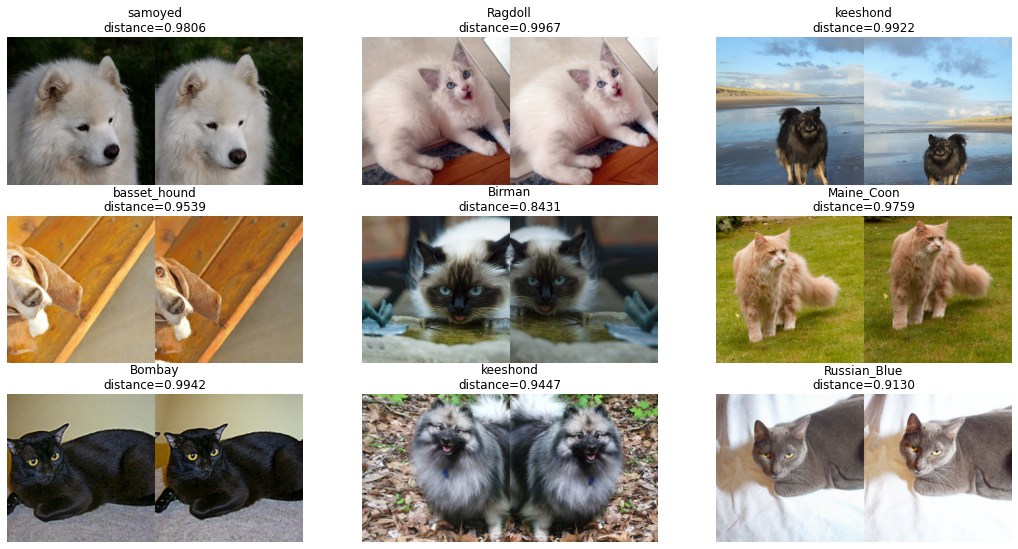

In [16]:
learn.show_results(0, max_n=18)

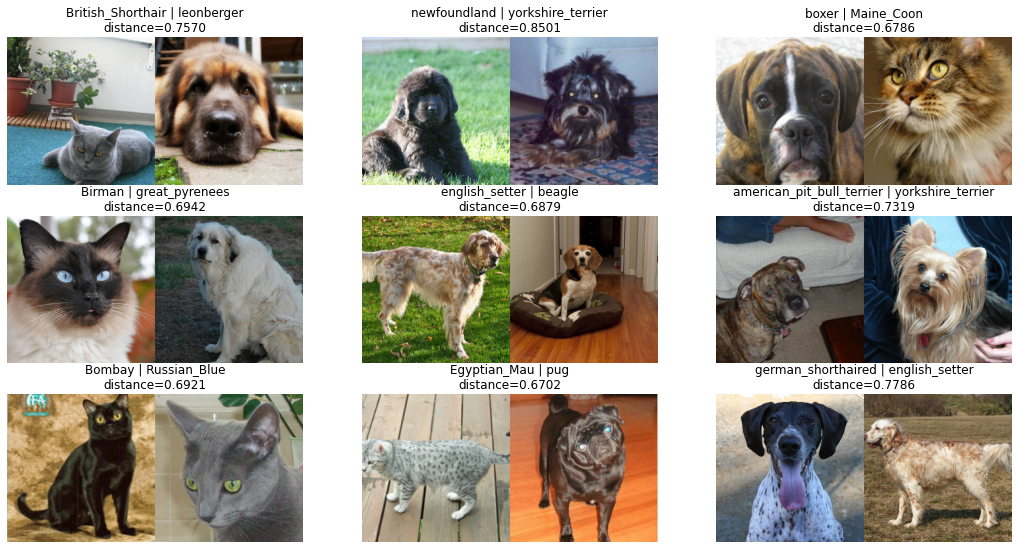

In [17]:
with double_augment.disabled(): learn.show_results(max_n=18)

# Visualize embeddings

In [18]:
with double_augment.disabled(): embs,lbls = learn.get_preds()
embs.shape,lbls.shape

(torch.Size([1478, 128]), torch.Size([1478]))

In [19]:
# conda install --channel conda-forge opentsne
from openTSNE import TSNE

In [20]:
def show_embeddings(embs, lbls, highlight_lbls=None, imsize=8, cmap=plt.cm.tab20):
    _,ax = plt.subplots(figsize=(imsize,imsize))
    colors = cmap(to_np(lbls))
    ax.scatter(tsne_embs[:,0], tsne_embs[:,1], c=colors, cmap=cmap, alpha=0.7 if highlight_lbls is None else 0.1)
    if highlight_lbls is not None:
        idxs = torch.where(L([lbls==o for o in highlight_lbls]).reduce(operator.or_))[0]
        ax.scatter(tsne_embs[idxs,0], tsne_embs[idxs,1], c=colors[idxs], cmap=cmap)
    return ax

In [21]:
tsne = TSNE(metric='cosine', n_jobs=-1)
%time tsne_embs = tsne.fit(to_np(embs))

CPU times: user 2min 30s, sys: 410 ms, total: 2min 31s
Wall time: 17.9 s


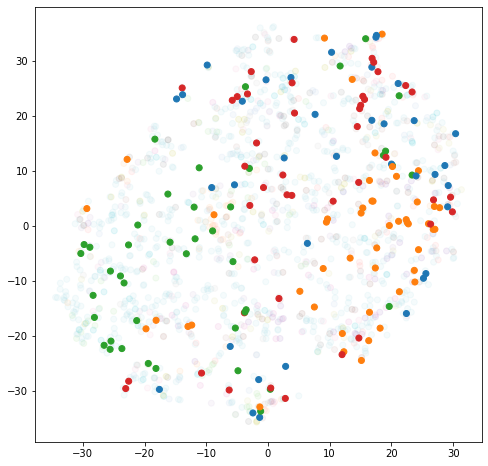

In [22]:
show_embeddings(tsne_embs, lbls, [0,2,4,6]);

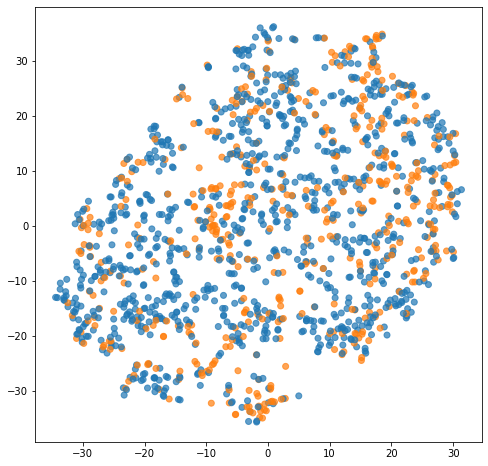

In [23]:
# Lets see only dogs vs cats
lbls2 = dls.vocab.map_ids(lbls).map(lambda x: int(x[0].isupper())).tensored()
show_embeddings(tsne_embs, lbls2, cmap=plt.cm.tab10);